<a href="https://colab.research.google.com/github/dikoharyadhanto/Machine_Learning_Project/blob/main/Project_Stock_Exchange_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

In [79]:
#!kaggle datasets download -d mattiuzc/stock-exchange-data

In [80]:
#!unzip -q stock-exchange-data.zip -d .

# **Data Preprocessing**

In [81]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [82]:
#Read IndexInfo
dataset_info = pd.read_csv('indexInfo.csv')
dataset_info.head(14)

,Region,Exchange,Index,Currency
0,United States,New York Stock Exchange,NYA,USD
1,United States,NASDAQ,IXIC,USD
2,Hong Kong,Hong Kong Stock Exchange,HSI,HKD
3,China,Shanghai Stock Exchange,000001.SS,CNY
4,Japan,Tokyo Stock Exchange,N225,JPY
5,Europe,Euronext,N100,EUR
6,China,Shenzhen Stock Exchange,399001.SZ,CNY
7,Canada,Toronto Stock Exchange,GSPTSE,CAD
8,India,National Stock Exchange of India,NSEI,INR
9,Germany,Frankfurt Stock Exchange,GDAXI,EUR


In [83]:
#Read IndexProcessed
df = pd.read_csv('indexProcessed.csv')
df.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


In [84]:
#Info Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104224 entries, 0 to 104223
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      104224 non-null  object 
 1   Date       104224 non-null  object 
 2   Open       104224 non-null  float64
 3   High       104224 non-null  float64
 4   Low        104224 non-null  float64
 5   Close      104224 non-null  float64
 6   Adj Close  104224 non-null  float64
 7   Volume     104224 non-null  float64
 8   CloseUSD   104224 non-null  float64
dtypes: float64(7), object(2)
memory usage: 7.2+ MB


In [85]:
#Merge IndexInfo and IndexProcessed
df = df.merge(dataset_info, on='Index')
df

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Region,Exchange,Currency
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006,Hong Kong,Hong Kong Stock Exchange,HKD
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013,Hong Kong,Hong Kong Stock Exchange,HKD
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987,Hong Kong,Hong Kong Stock Exchange,HKD
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987,Hong Kong,Hong Kong Stock Exchange,HKD
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013,Hong Kong,Hong Kong Stock Exchange,HKD
...,...,...,...,...,...,...,...,...,...,...,...,...
104219,J203.JO,2021-05-25,66054.921880,66812.453130,66022.976560,66076.679690,66076.679690,0.0,4625.367578,South Africa,Johannesburg Stock Exchange,ZAR
104220,J203.JO,2021-05-26,66076.679690,66446.367190,66030.351560,66108.226560,66108.226560,0.0,4627.575859,South Africa,Johannesburg Stock Exchange,ZAR
104221,J203.JO,2021-05-27,66108.226560,66940.250000,66102.546880,66940.250000,66940.250000,0.0,4685.817500,South Africa,Johannesburg Stock Exchange,ZAR
104222,J203.JO,2021-05-28,66940.250000,67726.562500,66794.609380,67554.859380,67554.859380,0.0,4728.840157,South Africa,Johannesburg Stock Exchange,ZAR


In [86]:
#Convert Data Types
df['Date'] = pd.to_datetime(df['Date'])
df['Index'] = df['Index'].astype('category')
df['Region'] = df['Region'].astype('category')
df['Exchange'] = df['Exchange'].astype('category')
df['Currency'] = df['Currency'].astype('category')

print(df.dtypes)

Index              category
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
CloseUSD            float64
Region             category
Exchange           category
Currency           category
dtype: object


In [87]:
#Checking Missing Values
df.isnull().sum()

Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
CloseUSD     0
Region       0
Exchange     0
Currency     0
dtype: int64

In [88]:
#I just want to analyze the specific index, so for this case, I will just analyze 'NYA' Index
df_NYA = df.loc[(df["Index"] == 'NYA')]
print('5 Baris Teratas:\n', df_NYA.head())
print('\n5 Baris Terbawah:\n', df_NYA.tail())
print('\nShape Dataset:\n', df_NYA.shape)

5 Baris Teratas:
      Index       Date  ...                 Exchange  Currency
8492   NYA 1965-12-31  ...  New York Stock Exchange       USD
8493   NYA 1966-01-03  ...  New York Stock Exchange       USD
8494   NYA 1966-01-04  ...  New York Stock Exchange       USD
8495   NYA 1966-01-05  ...  New York Stock Exchange       USD
8496   NYA 1966-01-06  ...  New York Stock Exchange       USD

[5 rows x 12 columns]

5 Baris Terbawah:
       Index       Date  ...                 Exchange  Currency
22434   NYA 2021-05-24  ...  New York Stock Exchange       USD
22435   NYA 2021-05-25  ...  New York Stock Exchange       USD
22436   NYA 2021-05-26  ...  New York Stock Exchange       USD
22437   NYA 2021-05-27  ...  New York Stock Exchange       USD
22438   NYA 2021-05-28  ...  New York Stock Exchange       USD

[5 rows x 12 columns]

Shape Dataset:
 (13947, 12)


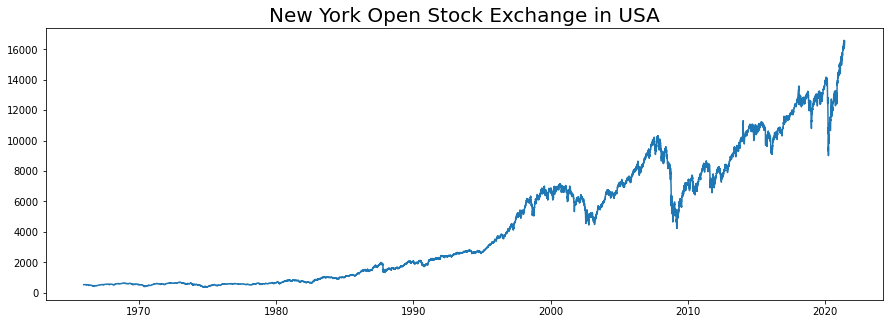

In [89]:
#Plotting dataset 'Open' and dates
plt.figure(figsize=(15,5))
plt.plot(df_NYA['Date'], df_NYA['Open'])
plt.title('New York Open Stock Exchange in USA', fontsize=20);

In [90]:
minMAE = (df_NYA['Open'].max() - df_NYA['Open'].min()) * (10/100)
minMAE

1624.2659701000002

In [91]:
#Variables for training
cols = list(df_NYA)[2:7]

df_cols = df_NYA[cols].astype(float)

In [92]:
#LSTM used sigmoid and tanh that are sensitive to magnitude so values need to be normalized
#normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_cols)
df_cols_scaled = scaler.transform(df_cols)

In [93]:
dates = df_NYA['Date'].values
open = df_NYA['Open'].values

In [94]:
dates = np.asarray(dates).astype('float32')
open= np.asarray(open).astype('float32')

In [95]:
#As required for LSTM networks, require to reshape an input data into n_samples x timesteps
#In this example, the n_features is 2. I will make timesteps = 3
#With this, the resultant n_samples is 5 (as the input data has 9 rows)
trainX = []
trainY = []

n_future = 1 #Number of days I want to predict into the future
n_past = 14 # Number of past days I want to use to predict the future


for i in range(n_past, len(df_cols_scaled) - n_future+1):
  trainX.append(df_cols_scaled[i - n_past:i, 0:df_cols.shape[1]])
  trainY.append(df_cols_scaled[i + n_future - 1:i + n_future,0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape)) #holding 14 days that are looking back and 5 variables that we got
print('trainY shape == {}.'.format(trainY.shape)) # 1 is the day after n_past

trainX shape == (13933, 14, 5).
trainY shape == (13933, 1).


In [96]:
 model = tf.keras.models.Sequential([
                                     tf.keras.layers.LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
                                     tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
                                     tf.keras.layers.Dropout(0.2),
                                     tf.keras.layers.Dense(32, activation="relu"),
                                     tf.keras.layers.Dense(trainY.shape[1])    
                                   ])
 
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
  
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 64)            17920     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 31,425
Trainable params: 31,425
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [97]:
#Membuat fungsi callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nmae kurang dari 10%")
      self.model.stop_training = True
callbacks = myCallback()

In [98]:
#Training Model
history = model.fit(trainX, trainY, batch_size=16, validation_split=0.2, epochs=50, verbose=2, callbacks=[callbacks])

Epoch 1/50
697/697 - 14s - loss: 0.1457 - mae: 0.4635 - val_loss: 0.9761 - val_mae: 1.4698
Epoch 2/50
697/697 - 11s - loss: 0.0634 - mae: 0.2461 - val_loss: 0.6508 - val_mae: 1.1256
Epoch 3/50
697/697 - 10s - loss: 0.0385 - mae: 0.1977 - val_loss: 0.3924 - val_mae: 0.8349
Epoch 4/50
697/697 - 10s - loss: 0.0268 - mae: 0.1681 - val_loss: 0.1992 - val_mae: 0.5854
Epoch 5/50
697/697 - 10s - loss: 0.0217 - mae: 0.1524 - val_loss: 0.0907 - val_mae: 0.3971
Epoch 6/50
697/697 - 10s - loss: 0.0178 - mae: 0.1364 - val_loss: 0.0430 - val_mae: 0.2752
Epoch 7/50
697/697 - 10s - loss: 0.0164 - mae: 0.1296 - val_loss: 0.0219 - val_mae: 0.1948
Epoch 8/50
697/697 - 10s - loss: 0.0153 - mae: 0.1237 - val_loss: 0.0129 - val_mae: 0.1473
Epoch 9/50
697/697 - 10s - loss: 0.0143 - mae: 0.1202 - val_loss: 0.0100 - val_mae: 0.1246
Epoch 10/50
697/697 - 10s - loss: 0.0133 - mae: 0.1156 - val_loss: 0.0092 - val_mae: 0.1119
Epoch 11/50
697/697 - 10s - loss: 0.0126 - mae: 0.1107 - val_loss: 0.0095 - val_mae: 0.11

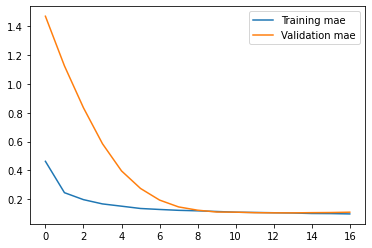

In [99]:
#Plot mae
plt.plot(history.history['mae'], label='Training mae')
plt.plot(history.history['val_mae'], label='Validation mae')
plt.legend()

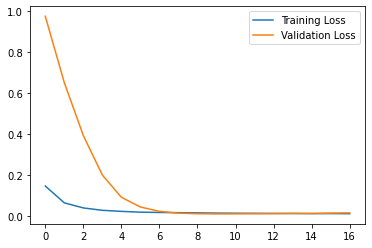

In [100]:
#Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

# **Forecasting**

In [101]:
#Start with the last day in training date and predict future
n_future = 360 #Redefining n_future to extend prediction dates beyond original n_future dates
forecast_period_dates = pd.date_range(list(df_NYA['Date'])[-30], periods=n_future, freq='1d').tolist()

print(forecast_period_dates)

[Timestamp('2021-05-28 00:00:00', freq='D'), Timestamp('2021-05-29 00:00:00', freq='D'), Timestamp('2021-05-30 00:00:00', freq='D'), Timestamp('2021-05-31 00:00:00', freq='D'), Timestamp('2021-06-01 00:00:00', freq='D'), Timestamp('2021-06-02 00:00:00', freq='D'), Timestamp('2021-06-03 00:00:00', freq='D'), Timestamp('2021-06-04 00:00:00', freq='D'), Timestamp('2021-06-05 00:00:00', freq='D'), Timestamp('2021-06-06 00:00:00', freq='D'), Timestamp('2021-06-07 00:00:00', freq='D'), Timestamp('2021-06-08 00:00:00', freq='D'), Timestamp('2021-06-09 00:00:00', freq='D'), Timestamp('2021-06-10 00:00:00', freq='D'), Timestamp('2021-06-11 00:00:00', freq='D'), Timestamp('2021-06-12 00:00:00', freq='D'), Timestamp('2021-06-13 00:00:00', freq='D'), Timestamp('2021-06-14 00:00:00', freq='D'), Timestamp('2021-06-15 00:00:00', freq='D'), Timestamp('2021-06-16 00:00:00', freq='D'), Timestamp('2021-06-17 00:00:00', freq='D'), Timestamp('2021-06-18 00:00:00', freq='D'), Timestamp('2021-06-19 00:00:00'

In [102]:
forecast = model.predict(trainX[-n_future:])

In [103]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, just copy the values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_cols.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [104]:
#Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
  forecast_dates.append(time_i.date())

In [105]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

print('5 Baris Teratas:\n', df_forecast.head())
print('\n5 Baris Terbawah:\n', df_forecast.tail())
print('\nShape Dataset:\n', df_forecast.shape)

5 Baris Teratas:
         Date          Open
0 2021-05-28  14913.015625
1 2021-05-29  14965.513672
2 2021-05-30  15017.748047
3 2021-05-31  15063.517578
4 2021-06-01  15100.078125

5 Baris Terbawah:
           Date          Open
355 2022-05-18  19905.191406
356 2022-05-19  19924.875000
357 2022-05-20  19934.314453
358 2022-05-21  19950.966797
359 2022-05-22  19969.701172

Shape Dataset:
 (360, 2)


In [108]:
original = df_NYA[['Date', 'Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-06-01']

print('5 Baris Teratas:\n', original.head())
print('\n5 Baris Terbawah:\n', original.tail())
print('\nShape Dataset:\n', original.shape)

5 Baris Teratas:
             Date         Open
22187 2020-06-01  11799.91992
22188 2020-06-02  11900.24023
22189 2020-06-03  12175.05957
22190 2020-06-04  12236.74023
22191 2020-06-05  12640.98047

5 Baris Terbawah:
             Date         Open
22434 2021-05-24  16375.00000
22435 2021-05-25  16464.68945
22436 2021-05-26  16390.18945
22437 2021-05-27  16451.96094
22438 2021-05-28  16531.94922

Shape Dataset:
 (252, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


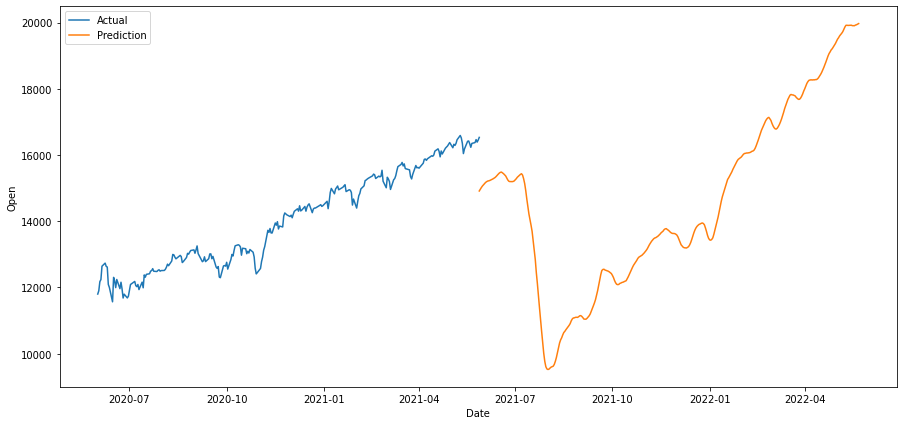

In [116]:
fig, ax = plt.subplots(figsize = (15, 7))

sns.lineplot(ax = ax, x='Date', y='Open', data=original)
sns.lineplot(ax = ax, x='Date', y='Open', data=df_forecast)
plt.legend(labels=["Actual","Prediction"])